In [1]:
#importing the necessary libraries
from py2neo import *
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
#nltk.download('stopwords') # run this one time
#nltk.download('punkts')
import numpy as np
import re


In [2]:
# Graph Initialisation for Importing Data from NoSQL Database(Neo4j)

driver = Graph("", auth=("neo4j", "Neo4j"))

uri = ""
user = "neo4j"
password = "Neo4j"

print("Stage 1.Graph Initiation")
yelp_graph = Graph(uri=uri, user=user, password=password)

yelp_graph.begin()

Stage 1.Graph Initiation


<b>Exploratory Data Analysis using Neo4j Cypher Queries<b>

In [3]:
print("1. The total number of records for business,users,reviews and categories in Neo4j Database after import\n")
print(yelp_graph.run("match (n) return head(labels(n)) as Label, count(*) as Records").to_table())


1. The total number of records for business,users,reviews and categories in Neo4j Database after import

 Label    | Records 
----------|---------
 business |   18153 
 cat      |    1714 
 user     |   12988 
 review   |   10000 



In [4]:
print("2. Top 10 users who have given most of the reviews\n")
print(yelp_graph.run("match (u:user) with u,size( (u)-[:WROTE]->()) as Posts order by Posts desc limit 10 return u.uid as UserID,u.Name as UserName, Posts").to_table())

2. Top 10 users who have given most of the reviews

 UserID                 | UserName      | Posts 
------------------------|---------------|-------
 YHWsLBS8jzZiPjKHMFOaAA | TOFoodReviews |   105 
 UGW-9bbBEB3eP1o6mWD_WA | Janet         |    78 
 YgavGxfAdjhkkbwlAY_9ZQ | Michelle      |    73 
 OQT9DjfBrzrwOEdVJjuYIA | Bee           |    63 
 PkRFSQgSfca9Tamq7b2LdQ | null          |    63 
 AuIK5tF2GjO7SftHawTLKw | Jaymee        |    61 
 0pf5VuzE4_1pwj5NJHG5TQ | null          |    59 
 q3AiAe-AcpDrNsdZf8nCvQ | null          |    52 
 kBNFdviedCPFWyR-wVaAzw | null          |    46 
 KjT3D4gZd5B-_WKgzmWjKg | Charlene      |    45 



In [5]:
print("3. Top 10 Businesses under multiple categories\n")
print(yelp_graph.run("MATCH (n:business) with n,size((n)-[:IN_CATEGORY]->()) as Categories order by Categories desc limit 10 return n.Bid as BusinessID,n.Name as BusinessName,Categories;").to_table())

3. Top 10 Businesses under multiple categories

 BusinessID             | BusinessName                     | Categories 
------------------------|----------------------------------|------------
 FB6OfSEepN2OEMu3Uw2ImA | Magnolia Emporium                |         19 
 FGL-4F9q8f1su5gAt8g4CQ | Margoa Aquatic Bodywork          |         15 
 ljkkLrW1j-tZtrJq9SFjVQ | Hempful Farms                    |         15 
 In1B_y225-bJw3jfbk1uAA | Ako International Market         |         15 
 6fsEuvtwwaX6VnJiWN-k4Q | Mommy 2B Experience              |         15 
 CtrbT5RPibrGfiq8tSHVTQ | PANDA Carpet and Tile Cleaning   |         15 
 eva56motCJcevOwKzyQO1g | Schenley Park Visitors Center    |         15 
 hTF1Qo6PRFnDgg1rh9a9BQ | Bridal Path Invitations Boutique |         14 
 sAMQU5CtyGiG4ZwRczN61g | VIVA IV Therapy                  |         14 
 -L9TeQN_JgLBvqf9wmsBVQ | The Broken Spoke                 |         14 



In [6]:
print(yelp_graph.run("MATCH (r:review)-[:REVIEWED]->(b:business) WHERE b.Bid = 'FB6OfSEepN2OEMu3Uw2ImA' return b.Bid as BusinessID,b.Name as BusinessName,b.city as City,b.state as State, b.review_count as numberofreviews,b.stars as numberofstars,r.text as REVIEW_TEXT").to_data_frame())

Empty DataFrame
Columns: []
Index: []


<b> Exploratory data Analysis using other Python libraries

In [7]:
print("Retreiving all reviews text and their ids from neo4j to python and storing them into a dataframe\n")
reviews_df = yelp_graph.run("MATCH (r:review) RETURN r.rid,r.date,r.text,r.stars,r.useful").to_data_frame()

reviews_df.head()

Retreiving all reviews text and their ids from neo4j to python and storing them into a dataframe



,r.date,r.rid,r.stars,r.text,r.useful
0,2014-01-27,jYrqbQ0bJxZLLyFS8shuAg,3,"For the price, the lunch specials are well wor...",1
1,2016-06-22,oj03nFMkiq-9H-8Lx2ucXA,1,Terrible customer service. Was looking to buy...,5
2,2009-08-06,lt7nl9Zlmlo8Uq175yIVaA,3,My first time to try Brazilian Steakhouse a co...,0
3,2010-07-06,fvmbDYauSiZ20PapoJygMQ,5,The employees are for the most part very frien...,2
4,2017-06-16,BK3QDGUWzHYlWbv2DBhkWQ,1,"Has gone downhill, AVOID. Used to wash blanket...",1


In [8]:
print("Some basic analysis of the reviews_df dataframe\n")
reviews_df.describe()

Some basic analysis of the reviews_df dataframe



,r.stars,r.useful
count,10000.000000,10000.000000
mean,3.684300,1.073300
std,1.524095,2.503908
min,1.000000,0.000000
25%,2.000000,0.000000
50%,4.000000,0.000000
75%,5.000000,1.000000
max,5.000000,95.000000


In [9]:
#Number of attributes and total number of records
reviews_df.shape

(10000, 5)

r.stars
1    1699
2     860
3     916
4    1949
5    4576
Name: r.rid, dtype: int64


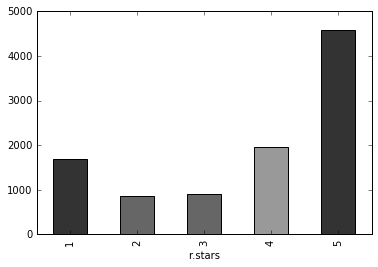

In [10]:
#Counting the number of review as per their stars
reviews=reviews_df.groupby(['r.stars'])['r.rid'].count()
print(reviews)
reviews.plot.bar(color=['0.2', '0.4', '0.4', '0.6'])

The count of 5 stars is maximum and the count of 2 stars is least.

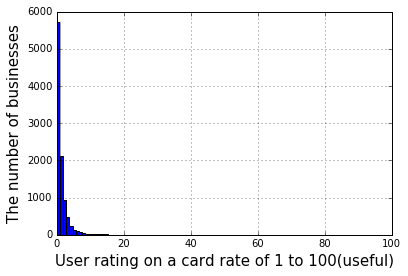

In [11]:
reviews_useful=reviews_df.groupby(['r.useful'])['r.rid'].count()
plt.xlabel("User rating on a card rate of 1 to 100(useful)",fontsize=15)
plt.ylabel("The number of businesses",fontsize=15)
reviews_df['r.useful'].hist(bins = 100)

Skewness=11.654
Statistics=0.413, p=0.000
Data does not look normal (reject H0)


C:\Users\VArun\AppData\Local\Enthought\Canopy\User\lib\site-packages\scipy\stats\morestats.py:1653: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


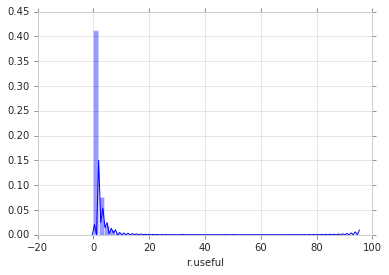

In [12]:
import seaborn as sns
from scipy.stats import shapiro
sns.set_style("whitegrid")   #background 
stat, p = shapiro(reviews_df['r.useful'])
print('Skewness=%.3f' %reviews_df['r.useful'].skew())
print('Statistics=%.3f, p=%.3f' %(stat, p))

alpha = 0.05
if p > alpha:
    print('Data looks normal (fail to reject H0)')
else:
    print('Data does not look normal (reject H0)')

sns.distplot(reviews_df['r.useful'])

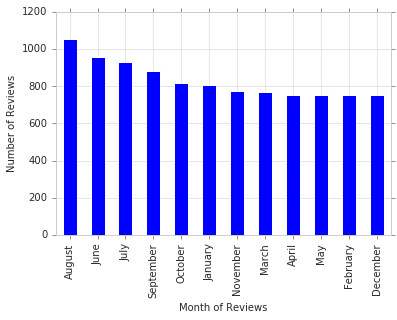

In [13]:
reviews_df['r.date'] = pd.to_datetime(reviews_df['r.date'])

reviews_month = reviews_df.groupby(reviews_df['r.date'].dt.strftime('%B'))['r.rid'].count()

reviews_month.sort_values(ascending=False).plot.bar()
plt.xlabel("Month of Reviews")
plt.ylabel("Number of Reviews")

<b> Data Preprocessing </b>

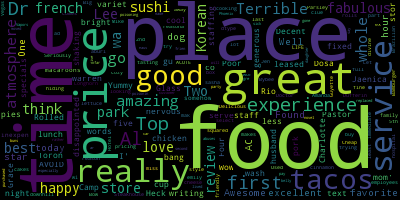

In [14]:
#Understanding the text words and its occurences in all the review text
review_text = reviews_df['r.text']
review_wordcloud = WordCloud().generate(str(review_text))

review_wordcloud.to_image()

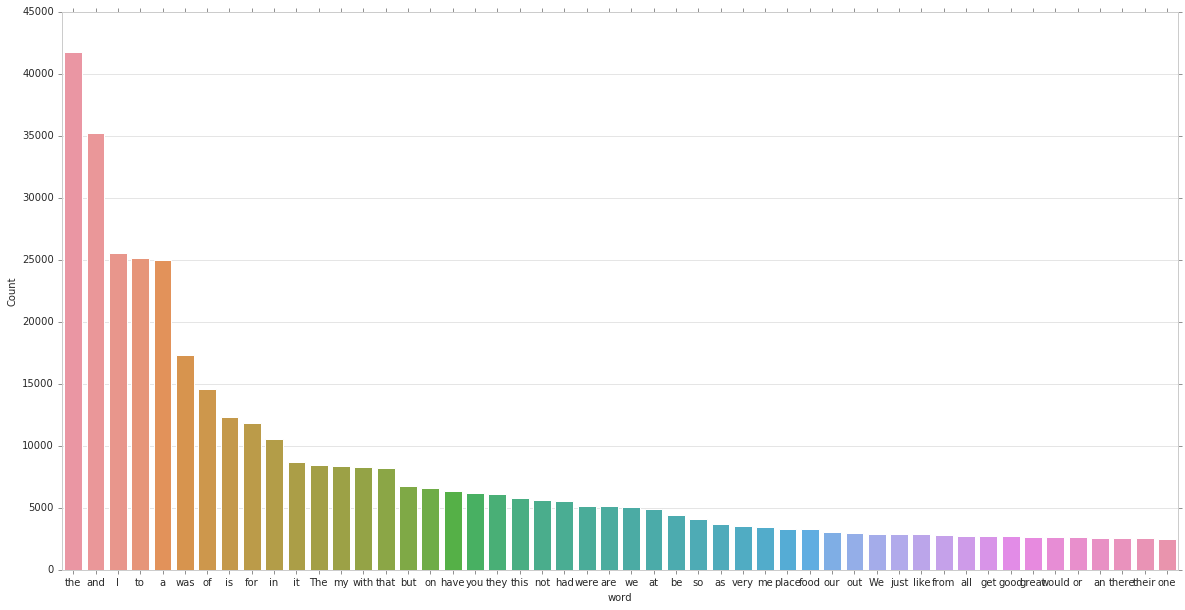

In [15]:
all_words = ' '.join(reviews_df['r.text'])
all_words = all_words.split()
fdist = nltk.FreqDist(all_words)
words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
#print(words_df)

# selecting top 50 most frequent words
d = words_df.nlargest(columns="count", n = 50) 
plt.figure(figsize=(20,10))
ax = sns.barplot(data=d, x= "word", y = "count")
ax.set(ylabel = 'Count')
plt.show()



In [16]:
#Data Cleaning Techniques

business_review=yelp_graph.run("MATCH (u:user)-[:WROTE]->(r:review)-[:REVIEWED]->(b:business)-[:IN_CATEGORY]->(c:cat) RETURN  r.rid,r.date,r.text,r.stars,r.useful,b.Bid,c.name").to_data_frame()

business_review['r.text']=business_review['r.text'].str.lower()
business_review['r.text']=business_review['r.text'].str.replace("[^a-zA-Z#]", " ")

# Load stop words
stop_words = stopwords.words('english')


stop_words.extend(['come','order','try','go','get','make','drink','plate','dish','restaurant','place','would','really','like','great','service','came','got','us','also','even','say','said','ciao','yummm','four','sleep','digit','star','monday','june','stay','staf','hate','good','food','time','one','back','order','love','well','price','order','nice','day','staff','please','let','thank','week','la','new','recommend','ago','went','perfect','pleas','work','definit','want','need','larg','excel'])


# Tokenization
business_review['r.text']=business_review['r.text'].apply(word_tokenize)
    
#Remove stop words
business_review['r.text']=business_review['r.text'].apply(lambda x: [word for word in x if word not in stop_words])

#Stemming through porterstemmer
porter_stemmer=PorterStemmer()
business_review['r.text']=business_review['r.text'].apply(lambda x:' '.join([porter_stemmer.stem(y) for y in x]))

business_review.tail()

#def more_stopwords(stop_words):

business_review.head()


,b.Bid,c.name,r.date,r.rid,r.stars,r.text,r.useful
0,alG1fb1kl2vmT8s34jbbHg,Beauty & Spas,2015-09-05,eShfPWENUmZ9sP7fstPt7Q,5,haircut cool atmospher peopl fair thorough lis...,1
1,alG1fb1kl2vmT8s34jbbHg,Hair Salons,2015-09-05,eShfPWENUmZ9sP7fstPt7Q,5,haircut cool atmospher peopl fair thorough lis...,1
2,s8PwBK300SvyJ-dxL-FOpg,Veterinarians,2016-09-03,HK53OvBgibiu7_v1VQK5wA,1,interest make money recommend extrem measur ne...,1
3,s8PwBK300SvyJ-dxL-FOpg,Pets,2016-09-03,HK53OvBgibiu7_v1VQK5wA,1,interest make money recommend extrem measur ne...,1
4,4Bw9XffSa0AMy2SrNCS2KA,Middle Eastern,2010-06-02,VQR9u5gWigPQqttg12zo-A,5,sababa move five statu strictli base falafel p...,2


In [120]:
#business_review_all=business_review.groupby(['b.Bid','r.rid','r.date','r.stars','r.text','r.useful'])['c.name'].apply('|'.join).reset_index()
#business_review_all.head()

,b.Bid,r.rid,r.date,r.stars,r.text,r.useful,c.name
0,-6tvduBzjLI1ISfs3F_qTg,XqDkYFxoE--SSzRKyqqVHA,2014-12-21,4,horchata frangelico mexican street corn chip s...,0,Restaurants| Nightlife| Mexican|Bars
1,-6tvduBzjLI1ISfs3F_qTg,Z1u7OmLi288HdwvkwBfKBw,2014-11-23,5,great nacho big great grill mahi taco hous mad...,0,Restaurants| Nightlife| Mexican|Bars
2,-6tvduBzjLI1ISfs3F_qTg,xo7heKrUGlf9-IqAEqaPng,2013-06-18,4,love place guacamol joyrid style soooooooo yum...,0,Restaurants| Nightlife| Mexican|Bars
3,-QK041S1Clr0N4m3adwRpA,hLwaP3bmZkRraS9Yzonkyg,2017-01-02,5,first time blown away result came realli nice ...,0,Hair Salons| Beauty & Spas|Hair Stylists| Hai...
4,0Zxeuxnutzsfe6V_VC5-wQ,lUMy8X1BShdlvDlkG4sF7w,2015-07-31,5,got car back today want express pleas servic r...,0,Body Shops| Automotive| Auto Glass Services|A...


In [17]:
all_words = ' '.join(business_review['r.text'])
all_words = all_words.split()
fdist = nltk.FreqDist(all_words)
words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
words=words_df.sort(['count'],ascending=[False])
words.head(50)

C:\Users\VArun\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,count,word
250,444,order
1142,361,wait
3114,361,friendli
2699,356,experi
1528,355,take
3558,351,tabl
143,349,call
602,345,best
3470,341,could
2786,338,look


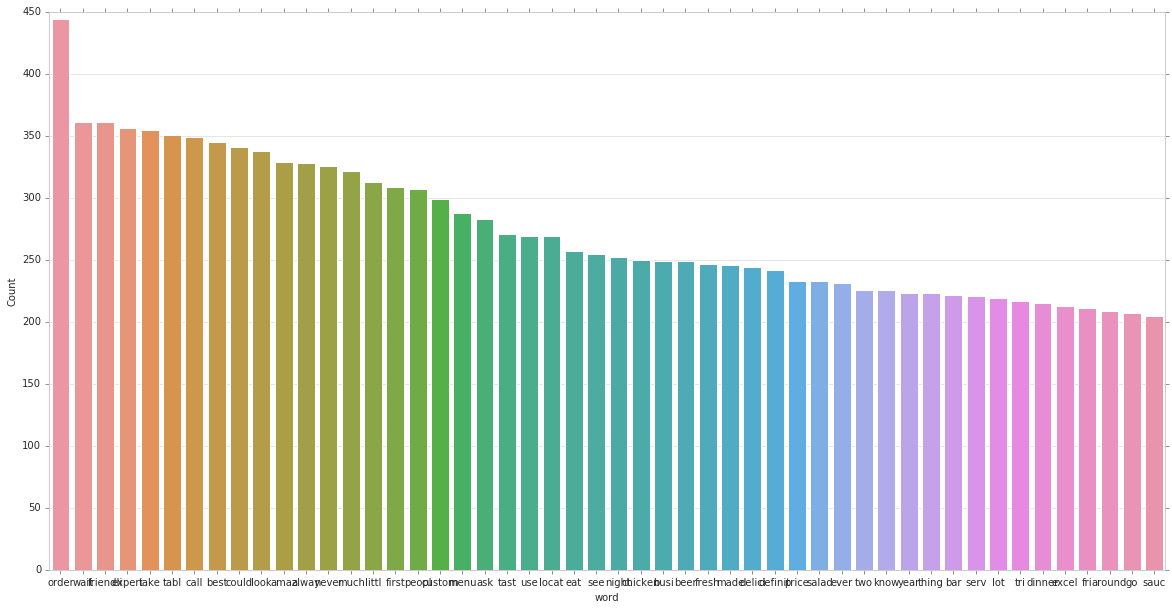

In [18]:
# selecting top 50 most frequent words
d = words_df.nlargest(columns="count", n = 50) 
plt.figure(figsize=(20,10))
ax = sns.barplot(data=d, x= "word", y = "count")
ax.set(ylabel = 'Count')
plt.show()


In [19]:
#To find the null values
#check missing values
business_review.columns[business_review.isnull().any()]

#missing value counts in each of these columns
sum_missingvalue = business_review.isnull().sum()
sum_missingvalue


b.Bid       0
c.name      0
r.date      0
r.rid       0
r.stars     0
r.text      0
r.useful    0
dtype: int64

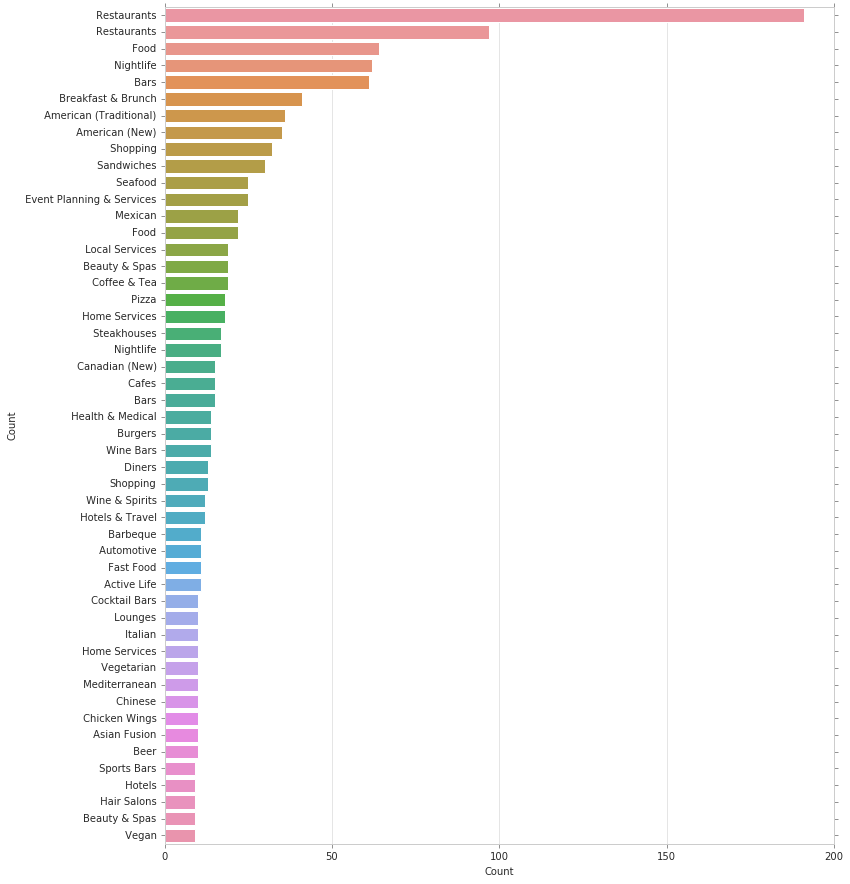

In [20]:
#same categories
all_categories = nltk.FreqDist(business_review['c.name']) 

# create dataframe
all_categories_df = pd.DataFrame({'Name': list(all_categories.keys()), 
                              'Count': list(all_categories.values())})
#print(all_categories_df)


g = all_categories_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Name") 
ax.set(ylabel = 'Count') 
plt.show()

In [21]:
#Replacing categories which are same
business_review['c.name']=business_review['c.name'].str.replace(" Restaurants", "Restaurants")
business_review['c.name']=business_review['c.name'].str.replace(" Shopping", "Shopping")
business_review['c.name']=business_review['c.name'].str.replace(" Nightlife", "Nightlife")
business_review['c.name']=business_review['c.name'].str.replace(" Food", "Food")
business_review['c.name']=business_review['c.name'].str.replace(" Bars", "Bars")
business_review['c.name']=business_review['c.name'].str.replace(" Mexican", "Mexican")
business_review['c.name']=business_review['c.name'].str.replace(" Thai", "Thai")

In [22]:
#same categories
all_categories = nltk.FreqDist(business_review['c.name']) 

# create dataframe
all_categories_df = pd.DataFrame({'Name': list(all_categories.keys()), 
                              'Count': list(all_categories.values())})

all_categories=all_categories_df.sort(['Count'],ascending=[False])
all_categories.tail(100)


C:\Users\VArun\AppData\Local\Enthought\Canopy\User\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,Count,Name
61,1,Car Dealers
85,1,Home Cleaning
81,1,Tobacco Shops
102,1,Public Transportation
78,1,PersonalShopping
77,1,Halal
76,1,Acai Bowls
75,1,Ethiopian
71,1,Kids Activities
70,1,Electronics Repair


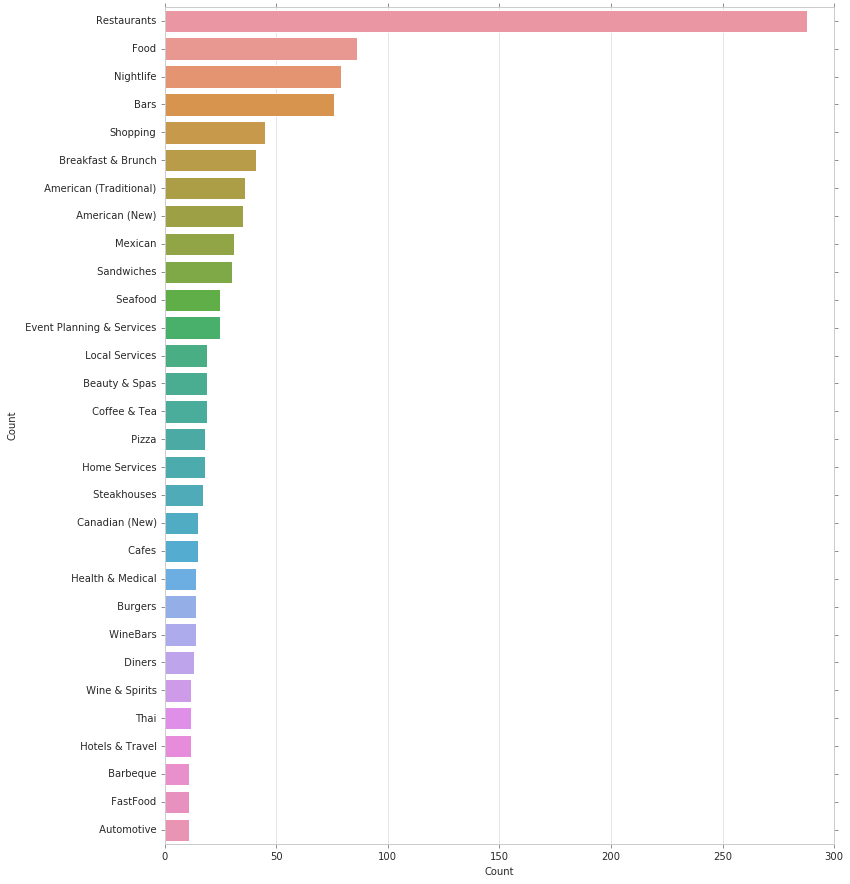

In [23]:
g = all_categories_df.nlargest(columns="Count", n = 30) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Name") 
ax.set(ylabel = 'Count') 
plt.show()

from sklearn import  preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.cross_validation import train_test_split
# split the dataset into training and validation datasets 
train_x, valid_x, train_y, valid_y = train_test_split(business_review['r.text'], business_review['c.name'], test_size=0.2, random_state=5)

# label encode the target variable 
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)

In [159]:
no_features=1000
# LDA can uses raw term counts since LDA is a probabilistic graphical model
tf_vectorizer = CountVectorizer(ngram_range=(1,2),max_df=0.4,min_df=10, max_features=no_features, stop_words='english')
cv_features = tf_vectorizer.fit(business_review['r.text'])
tf_feature_names = tf_vectorizer.get_feature_names()
#print("Dimensions for countvector are : ",cv_features.shape)
#print(cv_features.toarray())

# transform the training and validation data using count vectorizer object
xtrain_count =  tf_vectorizer.transform(train_x)
xvalid_count =  tf_vectorizer.transform(valid_x)

# Building a Tfid vector for frequency count of each word
tfidf=TfidfVectorizer(min_df=10,ngram_range=(1,2))
x_train_features = tfidf.fit_transform(business_review['r.text'])
tf_train_features_names = tfidf.get_feature_names()
print("Dimensions for train tfidf vector are : ",x_train_features.shape)

#print(tfidf_features.toarray())


('Dimensions for train tfidf vector are : ', (2116, 2249))


In [24]:
no_features=1000
# LDA can uses raw term counts since LDA is a probabilistic graphical model
tf_vectorizer = CountVectorizer(ngram_range=(1,2),max_df=0.4,min_df=10, max_features=no_features, stop_words='english')
cv_features = tf_vectorizer.fit_transform(business_review['r.text'])
tf_feature_names = tf_vectorizer.get_feature_names()
#print("Dimensions for countvector are : ",cv_features.shape)
#print(cv_features.toarray())


In [61]:
from sklearn.decomposition import LatentDirichletAllocation

n_components=20
lda=LatentDirichletAllocation(n_components,max_iter=50, learning_method='online',learning_offset=50.,random_state=100)
topics=lda.fit_transform(cv_features)

print(lda)
#lda_tfid=LatentDirichletAllocation(categories,max_iter=50, learning_method='online',learning_offset=50.,random_state=0).fit(x_train_features)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=50, mean_change_tol=0.001,
             n_jobs=1, n_topics=20, perp_tol=0.1, random_state=100,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)


In [62]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda.score(cv_features))
# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda.perplexity(cv_features))
# See model parameters
print(lda.get_params())

('Log Likelihood: ', -400281.5527772597)
('Perplexity: ', 549.0100895738975)
{'learning_offset': 50.0, 'n_jobs': 1, 'topic_word_prior': None, 'perp_tol': 0.1, 'evaluate_every': -1, 'max_iter': 50, 'mean_change_tol': 0.001, 'batch_size': 128, 'max_doc_update_iter': 100, 'learning_decay': 0.7, 'random_state': 100, 'doc_topic_prior': None, 'n_topics': 20, 'total_samples': 1000000.0, 'learning_method': 'online', 'verbose': 0}


In [70]:
from sklearn.grid_search import GridSearchCV
# Define Search Param
search_params = {'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}
# Init the Model
lda = LatentDirichletAllocation(max_iter=5, learning_method='online', learning_offset=50.,random_state=0)
# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)
# Do the Grid Search
model.fit(cv_features)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_jobs=1, n_topics=10, perp_tol=0.1, random_state=0,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_topics': [10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [71]:
# Best Model
best_lda_model = model.best_estimator_
# Model Parameters
print("Best Model's Params: ", model.best_params_)
# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)
# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(cv_features))

("Best Model's Params: ", {'n_topics': 10, 'learning_decay': 0.9})
('Best Log Likelihood Score: ', -158394.7068399801)
('Model Perplexity: ', 653.0955503889503)


In [72]:
from sklearn.decomposition import LatentDirichletAllocation

n_components=10
lda=LatentDirichletAllocation(n_components,max_iter=5, learning_method='online',learning_offset=50.,random_state=100)
topics=lda.fit_transform(cv_features)

print(lda)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50.0,
             max_doc_update_iter=100, max_iter=5, mean_change_tol=0.001,
             n_jobs=1, n_topics=10, perp_tol=0.1, random_state=100,
             topic_word_prior=None, total_samples=1000000.0, verbose=0)


In [73]:
#To print the top 10 words of each topic
def display_topics(model,feature_names,no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
print("\nTopics in LDA model: ")
display_topics(lda, tf_feature_names, no_top_words)

Topic 0:
amaz friendli price best alway fresh favorit definit stop littl
Topic 1:
custom compani use phone profession busi clean mani job day
Topic 2:
lot donut fresh store mean cafe treat today park spot
Topic 3:
tast chicken burrito wine pizza special spot home night water
Topic 4:
hotel eat breakfast meal night serv cook sure server wife
Topic 5:
ask wait order tabl minut year review told look better
Topic 6:
menu friend order salad pretti select bar sandwich seat fish
Topic 7:
locat date doctor hollywood bother walgreen finish beauti team stock
Topic 8:
experi burger dine peopl room thing look expect enjoy tabl
Topic 9:
beer meat sauc shrimp serv app vega dinner lobster wednesday


In [86]:
#For the Representation of word clouds for each topics
first_topic = lda.components_[0]
second_topic = lda.components_[1]
third_topic = lda.components_[2]
fourth_topic = lda.components_[3]
#first_topic.shape

first_topic_words = [tf_feature_names[i] for i in first_topic.argsort()[:-50 - 1 :-1]]
second_topic_words = [tf_feature_names[i] for i in second_topic.argsort()[:-50 - 1 :-1]]
third_topic_words = [tf_feature_names[i] for i in third_topic.argsort()[:-50 - 1 :-1]]
fourth_topic_words = [tf_feature_names[i] for i in fourth_topic.argsort()[:-50 - 1 :-1]]


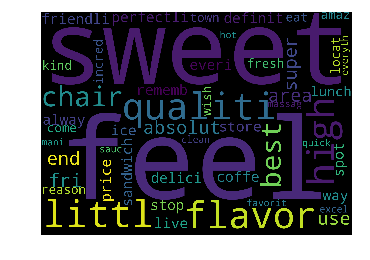

In [87]:
#First topic word cloud 
# Generating the wordcloud with the values under the category dataframe
print("First topic word cloud")
firstcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(first_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

Second Topic cloud


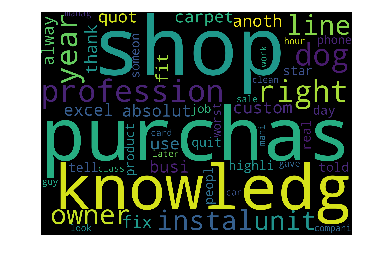

In [90]:
#Second topic word cloud 
# Generating the wordcloud with the values under the category dataframe
print("Second Topic cloud")
firstcloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          width=2500,
                          height=1800
                         ).generate(" ".join(second_topic_words))
plt.imshow(firstcloud)
plt.axis('off')
plt.show()

In [74]:
topic_values = lda.transform(cv_features)  
topic_values.shape

(2116L, 10L)

In [75]:
business_review['Topic'] = topic_values.argmax(axis=1)

In [76]:
business_review.head(20)

,b.Bid,c.name,r.date,r.rid,r.stars,r.text,r.useful,Topic
0,alG1fb1kl2vmT8s34jbbHg,Beauty & Spas,2015-09-05,eShfPWENUmZ9sP7fstPt7Q,5,haircut cool atmospher peopl fair thorough lis...,1,8
1,alG1fb1kl2vmT8s34jbbHg,Hair Salons,2015-09-05,eShfPWENUmZ9sP7fstPt7Q,5,haircut cool atmospher peopl fair thorough lis...,1,8
2,s8PwBK300SvyJ-dxL-FOpg,Veterinarians,2016-09-03,HK53OvBgibiu7_v1VQK5wA,1,interest make money recommend extrem measur ne...,1,5
3,s8PwBK300SvyJ-dxL-FOpg,Pets,2016-09-03,HK53OvBgibiu7_v1VQK5wA,1,interest make money recommend extrem measur ne...,1,5
4,4Bw9XffSa0AMy2SrNCS2KA,Middle Eastern,2010-06-02,VQR9u5gWigPQqttg12zo-A,5,sababa move five statu strictli base falafel p...,2,0
5,4Bw9XffSa0AMy2SrNCS2KA,Kosher,2010-06-02,VQR9u5gWigPQqttg12zo-A,5,sababa move five statu strictli base falafel p...,2,0
6,4Bw9XffSa0AMy2SrNCS2KA,Falafel,2010-06-02,VQR9u5gWigPQqttg12zo-A,5,sababa move five statu strictli base falafel p...,2,0
7,4Bw9XffSa0AMy2SrNCS2KA,Mediterranean,2010-06-02,VQR9u5gWigPQqttg12zo-A,5,sababa move five statu strictli base falafel p...,2,0
8,4Bw9XffSa0AMy2SrNCS2KA,Restaurants,2010-06-02,VQR9u5gWigPQqttg12zo-A,5,sababa move five statu strictli base falafel p...,2,0
9,BNubIia7rJAqSRxioUZGxg,Restaurants,2013-07-08,vLCqQ50Cucf0LcDzKtk4iA,5,lao thai curri amaz mani dish excel seat side ...,1,0


In [82]:
#Dominant Topics Keywords Matrix
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)
# Assign Column and Index
df_topic_keywords.columns = tf_feature_names
# column names
topicnames = ["Topic" + str(i) for i in range(10)]
df_topic_keywords.index = topicnames
# View
df_topic_keywords.head(10)

,abl,absolut,absolut amaz,accept,accommod,actual,ad,add,addit,advanc,...,write,wrong,ye,year,year old,yell,yelp,yesterday,york,yummi
Topic0,0.676915,0.479768,0.332297,0.270193,0.288045,1.709580,0.311216,3.383473,0.426720,0.297368,...,0.345375,0.262100,0.314923,0.296325,0.330477,0.290017,0.294350,0.322072,0.287752,8.480311
Topic1,0.589918,2.632743,0.553082,7.564843,0.833911,1.378941,1.281348,4.541263,0.406794,4.661135,...,6.339308,17.808551,2.738720,113.074134,14.975469,0.610008,10.073647,9.253523,0.435810,0.530592
Topic2,1.637125,0.366719,0.410713,0.316442,0.282099,0.852201,0.326199,0.302414,0.288741,0.307885,...,0.293216,0.273978,0.307689,0.327083,0.300225,0.331969,0.292546,0.345845,0.347356,0.256940
Topic3,4.347958,26.234589,1.530324,0.800007,0.547087,25.557620,14.654160,10.555130,12.564821,0.913635,...,3.270170,4.593892,0.473290,5.360752,0.460724,0.290624,5.209683,1.203084,1.745056,13.867722
Topic4,12.501113,0.346017,0.356459,0.274407,0.287232,1.728714,2.987877,0.300884,0.285533,0.300580,...,0.414050,0.498892,0.291226,1.642988,0.708438,0.679876,0.307398,0.277113,0.323323,0.296453
Topic5,2.700550,0.433777,0.421547,2.137675,0.497848,0.336131,5.878312,1.770339,6.544313,0.234140,...,2.977843,0.419060,0.975948,0.996392,0.798778,0.273626,3.786321,0.267715,0.821140,0.893210
Topic6,0.628919,15.229673,0.715220,6.622593,0.979440,0.452043,0.273339,3.150483,8.031210,0.272727,...,3.346399,8.861027,5.184493,29.398955,7.154526,0.313822,3.381691,0.295498,0.286489,0.266785
Topic7,27.142807,5.651830,0.257038,0.398744,4.288160,29.763074,9.980558,4.933700,5.925783,10.898545,...,1.981169,6.931889,38.362840,9.658199,1.685429,4.452573,1.671737,4.806372,2.658146,33.619343
Topic8,30.109411,66.591806,14.720338,0.301339,11.436180,18.013263,0.571221,2.751322,18.777301,0.483774,...,0.779749,8.731462,0.596517,20.238595,1.248902,5.612360,6.046569,1.066290,11.493866,1.045069
Topic9,0.698521,2.532002,4.439742,0.353462,11.463229,9.036956,4.292409,0.936072,0.887151,0.472344,...,0.552985,4.332258,0.735184,0.339443,0.303016,8.160989,0.472743,0.519802,0.344823,0.481470


In [83]:
# Show top n keywords for each topic
def show_topics(vectorizer=tf_vectorizer, lda_model=lda, n_words=20):
    keywords = np.array(tf_vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords
topic_keywords = show_topics(vectorizer=tf_vectorizer, lda_model=lda, n_words=15)
# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,amaz,friendli,price,best,alway,fresh,favorit,definit,stop,littl,everyth,come,delici,hot,everi
Topic 1,custom,compani,use,phone,profession,busi,clean,mani,job,day,work,peopl,instal,excel,fix
Topic 2,lot,donut,fresh,store,mean,cafe,treat,today,park,spot,busi,complex,tell,fruit,bakeri
Topic 3,tast,chicken,burrito,wine,pizza,special,spot,home,night,water,soup,pork,dinner,enjoy,tri
Topic 4,hotel,eat,breakfast,meal,night,serv,cook,sure,server,wife,locat,check,room,best,awesom
Topic 5,ask,wait,order,tabl,minut,year,review,told,look,better,visit,experi,way,arriv,use
Topic 6,menu,friend,order,salad,pretti,select,bar,sandwich,seat,fish,delici,tast,bit,lot,hour
Topic 7,locat,date,doctor,hollywood,bother,walgreen,finish,beauti,team,stock,wed,helen,wonder,invit,lisa
Topic 8,experi,burger,dine,peopl,room,thing,look,expect,enjoy,tabl,bar,think,bad,small,larg
Topic 9,beer,meat,sauc,shrimp,serv,app,vega,dinner,lobster,wednesday,delici,wait,dessert,bread,seafood


In [ ]:
Topics = ["Update Version/Fix Crash Problem","Download/Internet Access","Learn and Share","Card Payment","Notification/Support", 
          "Account Problem", "Device/Design/Password", "Language/Recommend/Screen Size", "Graphic/ Game Design/ Level and Coin", "Photo/Search"]
df_topic_keywords["Topics"]=Topics
df_topic_keywords

In [81]:
import pyLDAvis.sklearn

In [36]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.sklearn.prepare(lda, cv_features ,tf_vectorizer)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
16     13.381480        1       1 -0.180783  0.142434
7      11.514445        1       2 -0.025375  0.161311
8      11.047918        1       3  0.050389 -0.013237
10     10.137554        1       4 -0.120296  0.127046
5       8.307724        1       5  0.153418  0.119013
9       6.674675        1       6 -0.068314  0.028824
14      5.802484        1       7  0.003811  0.068593
13      4.421844        1       8  0.122308 -0.070871
1       4.358667        1       9  0.191404  0.021817
11      4.286412        1      10  0.141501 -0.007992
3       3.775288        1      11 -0.042182  0.100199
12      3.619001        1      12 -0.114479  0.066224
0       3.474793        1      13 -0.211030 -0.081077
15      3.325786        1      14 -0.043188 -0.071688
19      1.555125        1      15 -0.127829 -0.356559
2       1.304022        1      16 -0.081531 -0.037381
4       1.232149        1      17  0.199232 -0.022234
6       1.156486        1      18  0.113736 -0.124544
17      0.467399        1      19  0.045690 -0.074522
18      0.156745        1      20 -0.006482  0.024644, topic_info=     Category        Freq       Term       Total  loglift  logprob
term                                                              
628   Default  302.000000      peopl  302.000000  30.0000  30.0000
24    Default  330.000000       amaz  330.000000  29.0000  29.0000
74    Default  248.000000       beer  248.000000  28.0000  28.0000
934   Default  275.000000        use  275.000000  27.0000  27.0000
216   Default  294.000000     custom  294.000000  26.0000  26.0000
300   Default  352.000000     experi  352.000000  25.0000  25.0000
946   Default  354.000000       wait  354.000000  24.0000  24.0000
113   Default  171.000000    burrito  171.000000  23.0000  23.0000
676   Default  227.000000      price  227.000000  22.0000  22.0000
296   Default  217.000000      excel  217.000000  21.0000  21.0000
993   Default  226.000000       year  226.000000  20.0000  20.0000
432   Default  125.000000    husband  125.000000  19.0000  19.0000
1     Default  149.000000    absolut  149.000000  18.0000  18.0000
873   Default   96.000000       talk   96.000000  17.0000  17.0000
551   Default  174.000000      minut  174.000000  16.0000  16.0000
747   Default  198.000000       room  198.000000  15.0000  15.0000
711   Default  144.000000     reason  144.000000  14.0000  14.0000
21    Default  337.000000      alway  337.000000  13.0000  13.0000
347   Default  243.000000      fresh  243.000000  12.0000  12.0000
46    Default  289.000000        ask  289.000000  11.0000  11.0000
876   Default  262.000000       tast  262.000000  10.0000  10.0000
499   Default  268.000000      locat  268.000000   9.0000   9.0000
78    Default  337.000000       best  337.000000   8.0000   8.0000
102   Default  152.000000  breakfast  152.000000   7.0000   7.0000
387   Default  146.000000        guy  146.000000   6.0000   6.0000
495   Default  301.000000      littl  301.000000   5.0000   5.0000
63    Default  218.000000        bar  218.000000   4.0000   4.0000
529   Default   86.000000     massag   86.000000   3.0000   3.0000
595   Default  438.000000      order  438.000000   2.0000   2.0000
187   Default  140.000000       cook  140.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
724   Topic20    0.099463     rental   20.202926   1.1445  -6.9078
796   Topic20    0.099464       sign   94.164416  -0.3947  -6.9077
542   Topic20    0.099464       menu  290.520619  -1.5213  -6.9077
63    Topic20    0.099464        bar  218.469655  -1.2363  -6.9077
593   Topic20    0.099464     option  121.332259  -0.6482  -6.9077
135   Topic20    0.099464      chang  108.039447  -0.5322  -6.9077
652   Topic20    0.099464        plu   33.696887   0.6329  -6.9077
495   Topic20    0.099464      littl  301.896300  -1.5597  -6.9077
939   Topic20    0.099

In [43]:
from sklearn.cluster import KMeans
# Kmeans clustering
num_clusters = 7
km = KMeans(n_clusters=num_clusters, max_iter=1000)
km.fit(cv_features)
km.labels_.tolist()


array([6, 6, 6, ..., 6, 6, 6])

In [48]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tf_vectorizer.get_feature_names()
for i in range(num_clusters):
    top_ten_words = [terms[ind] for ind in order_centroids[i, :10]]
    print("Cluster {}: {}".format(i, ' '.join(top_ten_words)))

Top terms per cluster:
Cluster 0: wonder art felt friend relax feel schedul experi compani definit
Cluster 1: hotel room hollywood planet shop experi view work boyfriend know
Cluster 2: steak medium server brought check manag follow easili cook eat
Cluster 3: burrito steak fish halibut larg tri sauc big fat pull pork
Cluster 4: locat potato seafood season serv corn spici chicken combo garden
Cluster 5: tabl order menu seat bar wait peopl ask look server
Cluster 6: friendli best amaz order alway custom use littl tast experi


In [50]:
def Sentiment(x):
    if x < 3:
        return 0
    else:
        return 1
    
business_review['sentiments']=business_review['r.stars'].map(Sentiment)

In [51]:
from sklearn.cross_validation import train_test_split
xtrain, xval, ytrain, yval = train_test_split(business_review['r.text'],business_review['sentiments'] , test_size=0.2, random_state=5)

In [53]:
no_features=1000
# LDA can uses raw term counts since LDA is a probabilistic graphical model
tf_vectorizer = CountVectorizer(ngram_range=(1,2),max_df=0.4,min_df=10, max_features=no_features, stop_words='english')
cv_train_features = tf_vectorizer.fit_transform(xtrain)
cv_test_features=tf_vectorizer.transform(xval)
tf_feature_names = tf_vectorizer.get_feature_names()
print("Dimensions for countvector are : ",cv_features.shape)
#print(cv_features.toarray())

('Dimensions for countvector are : ', (2116, 1000))


In [64]:
from sklearn.decomposition import LatentDirichletAllocation

categories=20
lda=LatentDirichletAllocation(categories,max_iter=20, learning_method='online',learning_offset=50.,random_state=0)
train=lda.fit_transform(cv_train_features)
train

array([[ 0.05      ,  0.05      ,  0.05      , ...,  0.05      ,
         9.66881333,  0.05      ],
       [ 0.05      ,  0.05      ,  0.05      , ...,  0.05      ,
         0.05      ,  0.05      ],
       [ 0.05      ,  0.05      ,  0.05      , ...,  0.05      ,
        12.63366851,  0.05      ],
       ...,
       [ 0.05      ,  0.05      ,  0.05      , ...,  0.05      ,
         0.05      ,  0.05      ],
       [ 0.05      ,  0.05      ,  0.05      , ...,  4.27513437,
         0.05      ,  0.05      ],
       [ 0.05      ,  0.05      ,  0.05      , ...,  0.05      ,
         0.05      ,  0.05      ]])

In [68]:
categories=20
lda1=lda.transform(cv_test_features)
lda1

array([[ 0.05      ,  0.05      ,  0.05      , ...,  0.05      ,
         0.05      ,  0.05      ],
       [ 6.73257728,  0.05      ,  0.05      , ...,  0.05      ,
         0.05      ,  0.05      ],
       [ 7.32853334,  0.05      ,  6.74433456, ...,  0.05      ,
         0.05      ,  0.05      ],
       ...,
       [ 0.05      ,  0.05      ,  2.98850601, ...,  4.08536603,
         0.05      ,  0.05      ],
       [ 0.05      ,  0.05      ,  3.0324894 , ...,  0.05      ,
         0.05      ,  7.0675106 ],
       [ 0.05      ,  0.05      ,  0.05      , ...,  0.05      ,
        11.37538364,  0.05      ]])

In [69]:
# Building a Tfid vector for frequency count of each word
tfidf=TfidfVectorizer(min_df=10,ngram_range=(1,2))
x_train_features = tfidf.fit_transform(business_review['r.text'])
tf_train_features_names = tfidf.get_feature_names()
print("Dimensions for train tfidf vector are : ",x_train_features.shape)

('Dimensions for train tfidf vector are : ', (2116, 2249))


In [70]:
### Get Similarity Scores using cosine similarity
from sklearn.metrics.pairwise import cosine_similarity
sim_unigram=cosine_similarity(x_train_features)

In [72]:
def get_similar_articles(x):
    return ",".join(business_review['r.text'].loc[x.argsort()[-5:-1]])
business_review['similar_articles_unigram']=[get_similar_articles(x) for x in sim_unigram]

In [76]:
business_review['r.text'].str.strip()[3]

u'interest make money recommend extrem measur necessari kept push test inject hospit surgeri warrant vet assist front desk kept tri push expens procedur knew tri scam pay visit x ray reject recommend pet fine upset stomach fine next morn never follow next see pet okay disappoint awar'

In [77]:
business_review['similar_articles_unigram'].str.upper().str.strip().str.split("\n")[3]

[u'READI LOOK VET TREAT ANIM COMPASS RESPECT OWNER X MONTH OLD PUPPI SICK DIARRHEA RESULT VACCIN SEVER VISIT PAY LAB FEE RECOMMEND FOLLOW VISIT PUPPI GET BETTER EVERI ANOTH TREATMENT DOG SICK APPROACH DIAGNOSI RATHER SHOTGUN APPROACH THOUGH PAID HANDSOM DIAGNOSI QUICK UPDAT SINC STOP COME DOG HEALTHI PROVID SOLID INFORM VET UPSET CLINIC FEEL TOOK ADVANTAG IGNOR DOG OWNERSHIP SEEM SAW DOLLAR SIGN SAD AWAY PET,READI LOOK VET TREAT ANIM COMPASS RESPECT OWNER X MONTH OLD PUPPI SICK DIARRHEA RESULT VACCIN SEVER VISIT PAY LAB FEE RECOMMEND FOLLOW VISIT PUPPI GET BETTER EVERI ANOTH TREATMENT DOG SICK APPROACH DIAGNOSI RATHER SHOTGUN APPROACH THOUGH PAID HANDSOM DIAGNOSI QUICK UPDAT SINC STOP COME DOG HEALTHI PROVID SOLID INFORM VET UPSET CLINIC FEEL TOOK ADVANTAG IGNOR DOG OWNERSHIP SEEM SAW DOLLAR SIGN SAD AWAY PET,READI LOOK VET TREAT ANIM COMPASS RESPECT OWNER X MONTH OLD PUPPI SICK DIARRHEA RESULT VACCIN SEVER VISIT PAY LAB FEE RECOMMEND FOLLOW VISIT PUPPI GET BETTER EVERI ANOTH TREATMENT

In [91]:
business_review.head(10)

,b.Bid,c.name,r.date,r.rid,r.stars,r.text,r.useful,Topic
0,alG1fb1kl2vmT8s34jbbHg,Beauty & Spas,2015-09-05,eShfPWENUmZ9sP7fstPt7Q,5,haircut cool atmospher peopl fair thorough lis...,1,8
1,alG1fb1kl2vmT8s34jbbHg,Hair Salons,2015-09-05,eShfPWENUmZ9sP7fstPt7Q,5,haircut cool atmospher peopl fair thorough lis...,1,8
2,s8PwBK300SvyJ-dxL-FOpg,Veterinarians,2016-09-03,HK53OvBgibiu7_v1VQK5wA,1,interest make money recommend extrem measur ne...,1,5
3,s8PwBK300SvyJ-dxL-FOpg,Pets,2016-09-03,HK53OvBgibiu7_v1VQK5wA,1,interest make money recommend extrem measur ne...,1,5
4,4Bw9XffSa0AMy2SrNCS2KA,Middle Eastern,2010-06-02,VQR9u5gWigPQqttg12zo-A,5,sababa move five statu strictli base falafel p...,2,0
5,4Bw9XffSa0AMy2SrNCS2KA,Kosher,2010-06-02,VQR9u5gWigPQqttg12zo-A,5,sababa move five statu strictli base falafel p...,2,0
6,4Bw9XffSa0AMy2SrNCS2KA,Falafel,2010-06-02,VQR9u5gWigPQqttg12zo-A,5,sababa move five statu strictli base falafel p...,2,0
7,4Bw9XffSa0AMy2SrNCS2KA,Mediterranean,2010-06-02,VQR9u5gWigPQqttg12zo-A,5,sababa move five statu strictli base falafel p...,2,0
8,4Bw9XffSa0AMy2SrNCS2KA,Restaurants,2010-06-02,VQR9u5gWigPQqttg12zo-A,5,sababa move five statu strictli base falafel p...,2,0
9,BNubIia7rJAqSRxioUZGxg,Restaurants,2013-07-08,vLCqQ50Cucf0LcDzKtk4iA,5,lao thai curri amaz mani dish excel seat side ...,1,0


In [105]:
for index, row in business_review.iterrows():
    yelp_graph.run(''' MATCH (b:business{Bid:$business_id})
    MERGE (b)-[h:of_topic]->(t:topic {topic:$topic_name})
    ''', parameters = {'business_id': row['b.Bid'], 'topic_name': row['Topic']})